In [187]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
from datetime import datetime as dt
import matplotlib.pyplot as plt
from model import TimeSeriesPredictor
import pandas as pd
import numpy as np
import plotting

#### Выгрузим датасет international-airline-passengers

In [189]:
data = pd.read_csv(
    "../data/dataset/international-airline-passengers.csv",  
    delimiter=','
)

In [190]:
ts = pd.Series(
    data=data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'].values[:-1],
    index=data['Month'][:-1]
)

In [191]:
ts.index = [dt.strptime(x, '%Y-%m') for x in ts.index]

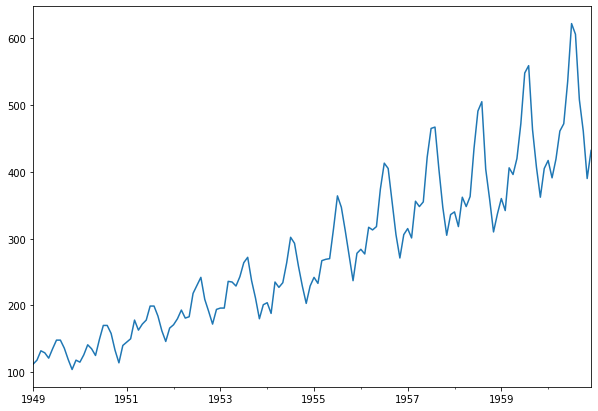

In [192]:
ts.plot(figsize=(10, 7))

### Применим модель TimeSeriesPredictor, написанную нами на прошлых занятиях

In [193]:
model = TimeSeriesPredictor(num_lags=12, granularity='month')

In [194]:
split_idx = 120

In [195]:
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [196]:
# обучим
model.fit(ts_train)

In [197]:
# предскажем на n точек вперед
preds = model.predict_next(ts_train, k=24)
plotting.plot_multiple_ts(ts, preds)

In [198]:
mean_absolute_error(ts_test, preds)

45.762290145480414

In [199]:
# а так же сделаем one_step_ahead предсказания
preds_one_step_ahead = model.predict_batch(ts_train, ts_test)
plotting.plot_multiple_ts(ts, preds_one_step_ahead)

In [200]:
mean_absolute_error(ts_test, preds_one_step_ahead)

18.518057160449555

#### C одной стороны, результаты весьма неплохие. C другой, хотелось бы иметь возможность подбирать гиперпараметры по сетке, как мы делаем в классических задачах машинного обучения.
#### Подбор гиперпараметров во временных рядах происходит почти также как и в классической задаче обучения с учителем, с тем лишь исключением, что для разбиения выборки используют скользящее окно по времени.

#### Как работает класс TimeSeriesSplit

In [201]:
from sklearn.model_selection import TimeSeriesSplit
matrix = model.enrich(model.transform(ts))
splitter = TimeSeriesSplit(n_splits=5)
batch_generator = splitter.split(ts)

In [202]:
next(batch_generator)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47]))

In [203]:
next(batch_generator)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71]))

In [204]:
next(batch_generator)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71]),
 array([72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
        89, 90, 91, 92, 93, 94, 95]))

### Задание
#### Добавьте в класс TimeSeriesPredictor метод  fit_params(self, ts, params, n_splits=4), который должен осуществлять следующие шаги  
* разбить входной ряд методом split класса TimeSeriesSplit
* для каждого батча обучить модель метдом fit на train и получить качество на test
(для этого не забудьте указать параметры **kwargs в сигнатуре метода fit TimeSeriesPredictor и передать их
дальше методу fit внутренней модели)
* получить усредненное качество на всех отложенных выборках
* вернуть его

#### Пример работы

In [206]:
model = TimeSeriesPredictor(num_lags=12, granularity='month')

In [207]:
model.fit_params(ts, params={'alpha': 4, 'solver': 'auto'})

6121.067726815859

In [208]:
ts_train, ts_test = ts[:120], ts[120:]

In [209]:
best_score = np.inf
best_params = {}
for alpha in [0.1, 0.4, 1, 2]:
    for solver in ['auto', 'svd', 'cholesky', 'lsqr']:
        params={'alpha': alpha, 'solver': solver}
        score = model.fit_params(ts_train, params=params)
        if score < best_score:
            best_score = score
            best_params = params

In [210]:
best_params

{'alpha': 2, 'solver': 'svd'}

In [211]:
best_score

16353.532709458406

In [212]:
model.fit(ts_train, **best_params)

In [213]:
ts_pred = model.predict_next(ts_train, k=len(ts_test))

In [214]:
plotting.plot_multiple_ts(ts, ts_pred)

In [215]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ts_test, ts_pred)

45.7342361058492